In [2]:
import os
import glob
import sys
import getpass
import importlib
from tqdm import tqdm
from pathlib import Path

# user path:
usrname = getpass.getuser()
# add paths:
sys.path.append(f'/Users/{usrname}/Desktop/Projects')
sys.path.append(f'/Users/{usrname}/Desktop/Projects/bimanual_wrist')
sys.path.append(f'/Users/{usrname}/Desktop/Projects/Functional_Fusion')
sys.path.append(f'/Users/{usrname}/Desktop/Projects/PcmPy')


import rsatoolbox as rsa
from rsatoolbox.io import spm as spm_io
import surfAnalysisPy as surf
import SUITPy as suit
import nibabel as nb
import nitools as nt
import PcmPy as pcm
import Functional_Fusion.atlas_map as am
import Functional_Fusion.reliability as rel

import matplotlib.pyplot as plt
import matplotlib
from matplotlib.cm import ScalarMappable
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import matplotlib.patches as patches
import seaborn as sns

import scipy.stats as stats
import scipy
import scipy.io as sio
import numpy as np
import pandas as pd

import utils
importlib.reload(utils)

# SET PATHS:
baseDir = os.path.join('/Users', getpass.getuser(), 'Desktop', 'Projects', 'bimanual_wrist', 'data', 'fMRI')
bidsDir = 'BIDS'
anatomicalDir = 'anatomicals'
freesurferDir = 'surfaceFreesurfer'
surfacewbDir = 'surfaceWB' 
behavDir = 'behavioural'
regDir = 'ROI'
atlasDir = '/Volumes/diedrichsen_data$/data/Atlas_templates/fs_LR_32'
analysisDir = os.path.join(os.path.dirname(os.path.dirname(baseDir)), 'analysis')



# Build dataset

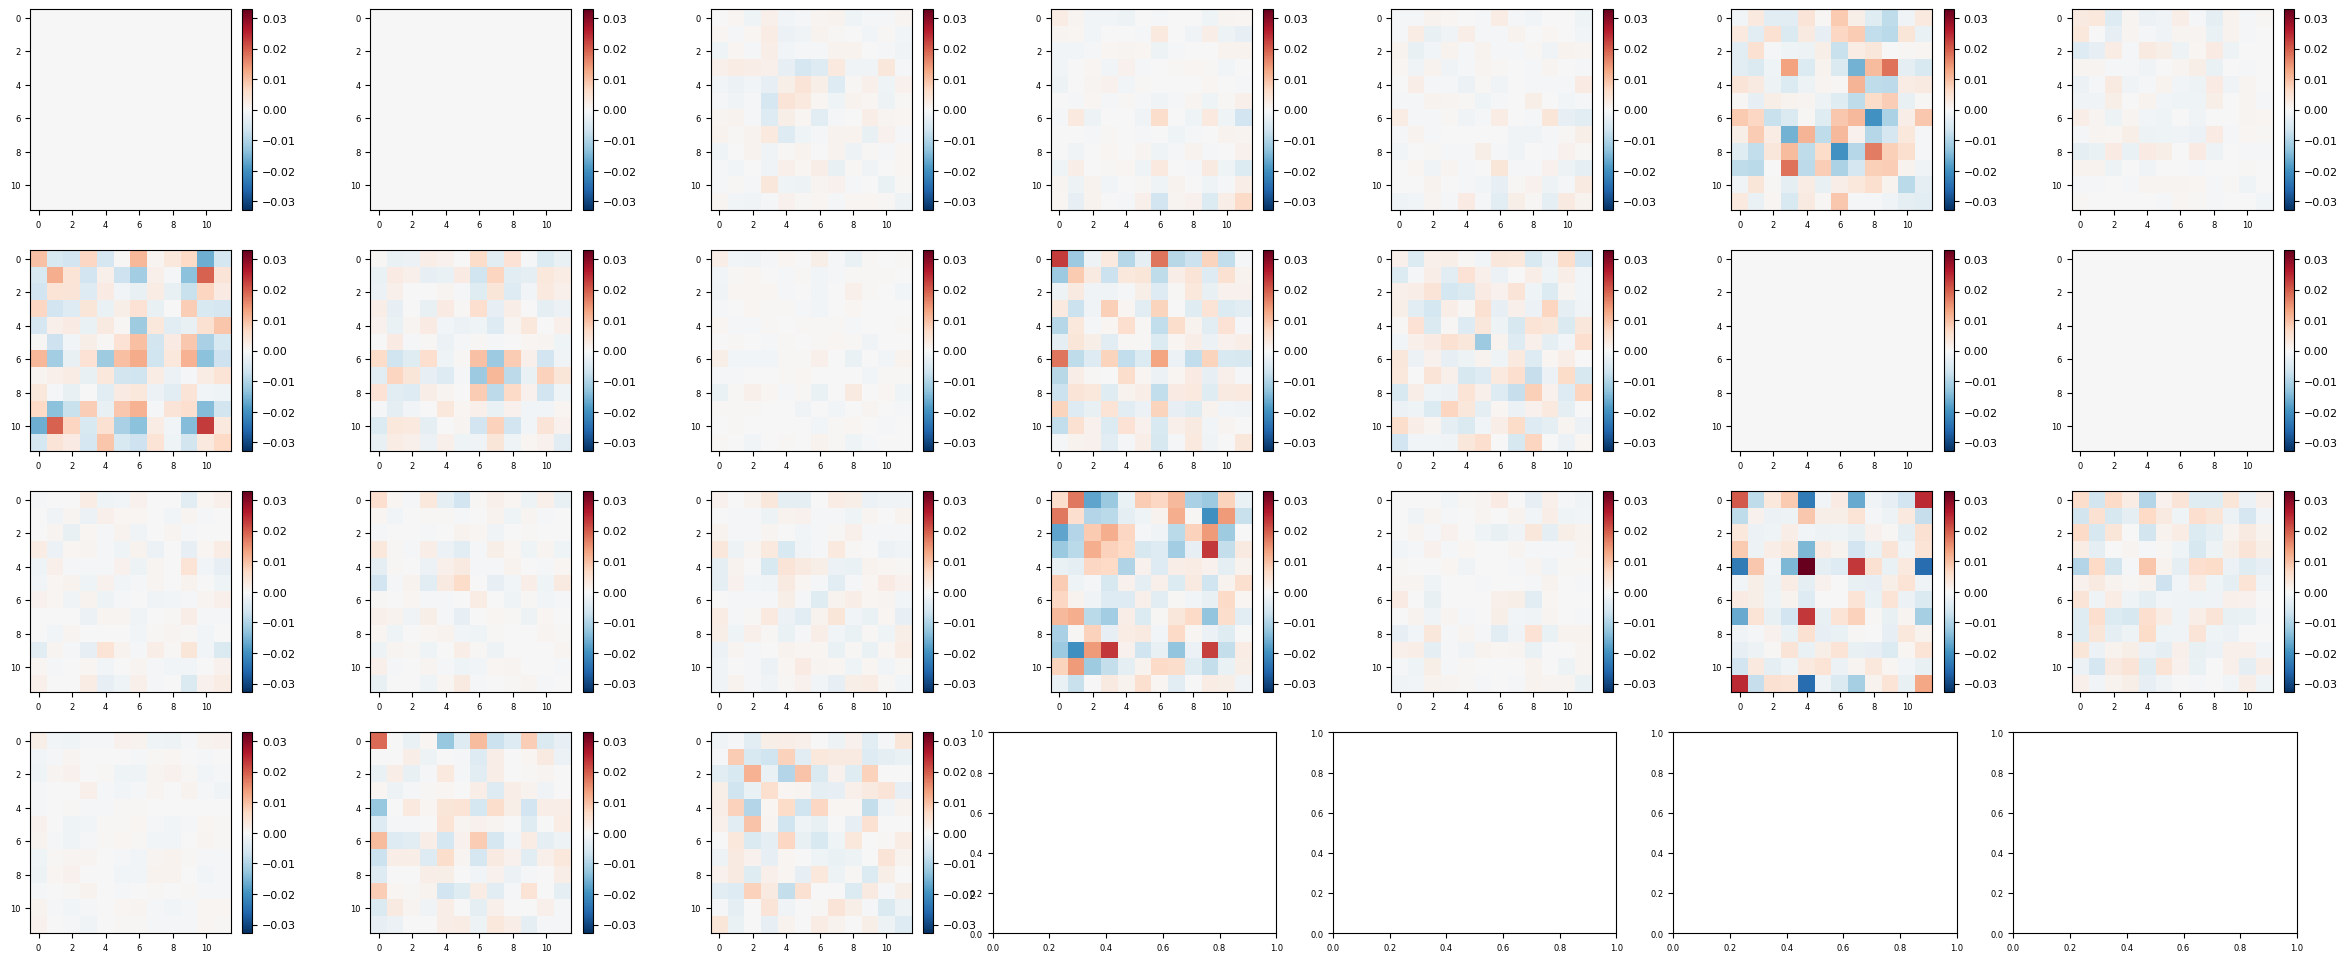

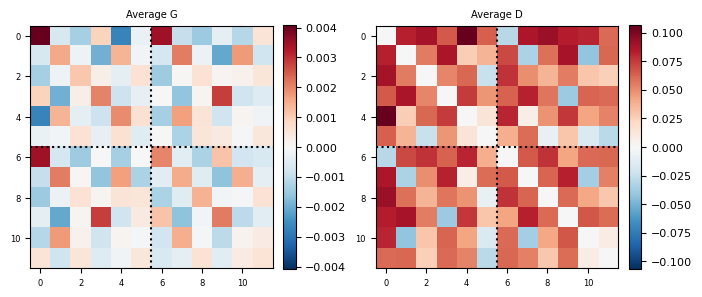

In [30]:
labels = ['flx', 'flxup', 'extup', 'ext', 'extdn', 'flxdn', 'flx', 'flxup', 'extup', 'ext', 'extdn', 'flxdn']
labels_lateral = ['contra']*6 + ['ipsi']*6
cmap = 'RdBu_r'
sn_bad = [102, 103]
regions = ['M1','S1','PMd','PMv','SMA','SPLa','SPLp','V1']
hem = ['L','R']

region = regions[2]
data, cond_vec, part_vec = [], [], []
for i_hem, h in enumerate(hem):
    roi = f'{region}_{h}'
    file_path = os.path.join(analysisDir, f'pwbeta_{roi}.npz')
    d = np.load(file_path, allow_pickle=True)

    subject = d['subject']
    indices = [k for k, s in enumerate(subject) if s not in sn_bad]

    subject = d['subject'][indices]
    cond_name_tmp = d['cond_intrinsic_vec'][indices]
    cond_vec_tmp = d['cond_num_vec'][indices]
    data_tmp = d['beta_white'][indices]
    part_tmp = d['part_vec'][indices]

    for i_sub in range(len(subject)):
        idx1 = [j for j, c in enumerate(cond_name_tmp[i_sub]) if 'rhand' in c]
        idx2 = [j for j, c in enumerate(cond_name_tmp[i_sub]) if 'lhand' in c]
        idx = idx1 + idx2
        # Y = data_tmp[i_sub][idx, :]
        Y1 = data_tmp[i_sub][idx1, :]
        Y2 = data_tmp[i_sub][idx2, :]

        # remove mean of voxels across conditions of rhand:
        rhand_parts = part_tmp[i_sub][idx1]
        for p in np.unique(rhand_parts):
            Y1[rhand_parts == p, :] = Y1[rhand_parts == p, :] - np.mean(Y1[rhand_parts == p, :], axis=0)
        # remove mean of voxels across conditions of lhand:
        lhand_parts = part_tmp[i_sub][idx2]
        for p in np.unique(lhand_parts):
            Y2[lhand_parts == p, :] = Y2[lhand_parts == p, :] - np.mean(Y2[lhand_parts == p, :], axis=0)
        Y = np.vstack((Y1, Y2))
        
        subj_part = part_tmp[i_sub][idx]
        # Sort based on Hemisphere to have contralateral first:
        if h == 'L':
            subj_cond = cond_vec_tmp[i_sub][idx]
            tmp = subj_cond.copy()
            subj_cond[tmp > 5] = tmp[tmp > 5] - 6
            subj_cond[tmp <= 5] = tmp[tmp <= 5] + 6 
        elif h == 'R':
            subj_cond = cond_vec_tmp[i_sub][idx]

        data.append(Y)
        cond_vec.append(np.array(subj_cond))
        part_vec.append(subj_part)

Y = []
# --- RDM Calculation ---
for i_sub in range(len(data)):
    obs_des = {'cond_vec': cond_vec[i_sub], 'part_vec': part_vec[i_sub]}
    Y.append(pcm.dataset.Dataset(data[i_sub], obs_descriptors=obs_des))

N = len(Y)
ncond = len(np.unique(Y[0].obs_descriptors['cond_vec']))
G_hat = np.zeros((N, ncond, ncond))
for i_sub in range(N):
    G_hat[i_sub, :, :], _ = pcm.est_G_crossval(Y[i_sub].measurements,
                                                Y[i_sub].obs_descriptors['cond_vec'],
                                                Y[i_sub].obs_descriptors['part_vec'],
                                                X=pcm.matrix.indicator(Y[i_sub].obs_descriptors['part_vec']))

# show all second moment matrices
cmap = 'RdBu_r'
fig,ax = plt.subplots(4,7,figsize=(30,12))
vmax = np.abs(G_hat).max()
for i in range(N):
    ax[i//7,i%7].imshow(G_hat[i,:,:],vmin=-vmax,vmax=vmax,cmap=cmap)
    # color bar:
    sm = ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=-vmax, vmax=vmax))
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax[i//7,i%7], fraction=0.046, pad=0.04)
    cbar.ax.tick_params(labelsize=8)

# avg:
fig, ax = plt.subplots(1,2,figsize=(7,3))
G_hat_avg = np.mean(G_hat, axis=0)
# G_hat_avg = G_hat_avg / np.trace(G_hat_avg)
vmax_avg = np.abs(G_hat_avg).max()
ax[0].imshow(G_hat_avg, vmin=-vmax_avg, vmax=vmax_avg, cmap=cmap)
sm = ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=-vmax_avg, vmax=vmax_avg))
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax[0], fraction=0.046, pad=0.04)
cbar.ax.tick_params(labelsize=8)
ax[0].set_title(f'Average G')
ax[0].axhline(5.5, color='k', linestyle=':', linewidth=1.5)
ax[0].axvline(5.5, color='k', linestyle=':', linewidth=1.5)

D_avg = pcm.G_to_dist(G_hat_avg)
D_avg = np.sign(D_avg) * np.sqrt(np.abs(D_avg))
vmax = np.abs(D_avg).max()
ax[1].imshow(D_avg, vmin=-vmax, vmax=vmax, cmap=cmap)
sm = ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=-vmax, vmax=vmax))
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax[1], fraction=0.046, pad=0.04)
cbar.ax.tick_params(labelsize=8)
ax[1].set_title(f'Average D')
ax[1].axhline(5.5, color='k', linestyle=':', linewidth=1.5)
ax[1].axvline(5.5, color='k', linestyle=':', linewidth=1.5)
plt.tight_layout()
plt.show() 




# Build models

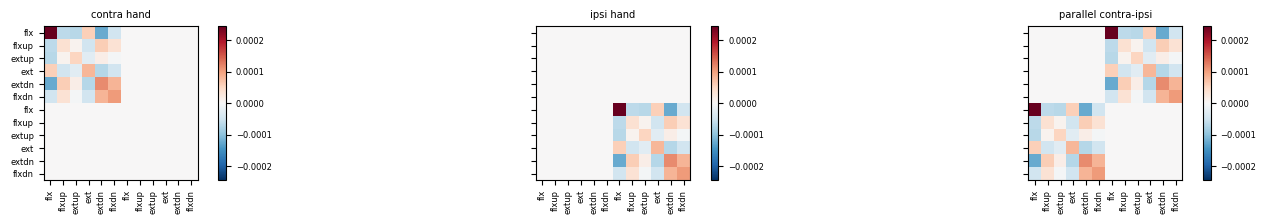

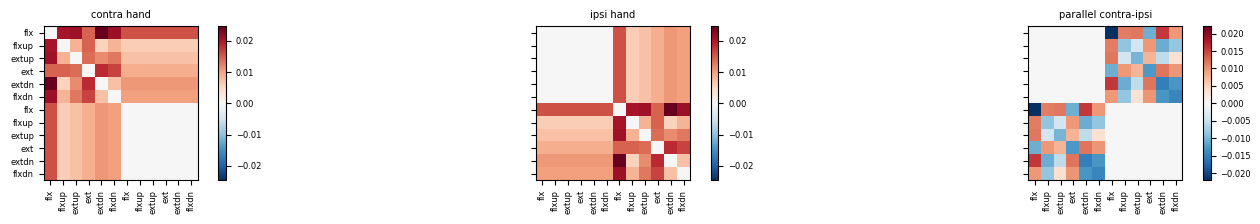

In [44]:
labels = ['flx', 'flxup', 'extup', 'ext', 'extdn', 'flxdn', 'flx', 'flxup', 'extup', 'ext', 'extdn', 'flxdn']
labels_lateral = ['contra']*6 + ['ipsi']*6
ncond = 12

M = []
modelG = {}

# Null model
cov = np.zeros((ncond, ncond))
M.append(pcm.FixedModel('null', cov))

# Contra hand structure:
ceil_fit = pd.read_pickle(os.path.join(analysisDir, f'PCM_unimanual_CVceiling_{region}.pkl'))
ceil = pcm.FreeModel('ceil',6)
params = ceil_fit['theta_cv'][0]
params = np.mean(params[0:21, :], axis=1)
G_ceil = ceil.predict(params)[0]
cov = np.zeros((ncond, ncond))
cov[0:6, 0:6] = G_ceil
# M.append(pcm.FixedModel('contra hand', cov))
modelG['contra hand'] = [cov]

# Ipsi hand structure:
cov = np.zeros((ncond, ncond))
cov[6:12, 6:12] = G_ceil
# M.append(pcm.FixedModel('ipsi hand', cov))
modelG['ipsi hand'] = [cov]

# Parallel contra-ipsi:
cov = np.zeros((ncond, ncond))
cov[0:6, 6:12] = G_ceil
cov[6:12, 0:6] = G_ceil
# cov = np.tile(G_ceil, (2,2))
# M.append(pcm.FixedModel('orth translation', cov))
modelG['parallel contra-ipsi'] = [cov]


# component models:
M.append(pcm.ComponentModel('only within_structure (orthogonal contra-ipsi)', [modelG['contra hand'][0], modelG['ipsi hand'][0]]))
M.append(pcm.ComponentModel('within_structure+parallel contra-ipsi', [modelG['contra hand'][0], modelG['ipsi hand'][0], modelG['parallel contra-ipsi'][0]]))

# PLOT:
n = len(modelG)
fix, ax = plt.subplots(1,n, figsize=(18,2), sharey=True)
for i in range(n):
    vmin = -np.max(np.abs(modelG[list(modelG.keys())[i]]))
    vmax = np.max(np.abs(modelG[list(modelG.keys())[i]]))
    ax[i].imshow(modelG[list(modelG.keys())[i]][0], cmap=cmap, vmin=vmin, vmax=vmax)
    ax[i].set_title(list(modelG.keys())[i])
    ax[i].set_xticks(list(range(12)))
    ax[i].set_xticklabels(labels, rotation=90)
    ax[i].set_yticks(list(range(12)))
    ax[i].set_yticklabels(labels)
    plt.colorbar(ax[i].imshow(modelG[list(modelG.keys())[i]][0], cmap=cmap, vmin=vmin, vmax=vmax), ax=ax[i])
plt.show()

fix, ax = plt.subplots(1,n, figsize=(18,2), sharey=True)
for i in range(n):
    D = pcm.G_to_dist(modelG[list(modelG.keys())[i]][0])
    D = np.sign(D) * np.sqrt(np.abs(D))
    vmin = -np.max(np.abs(D))
    vmax = np.max(np.abs(D))
    ax[i].imshow(D, cmap=cmap, vmin=vmin, vmax=vmax)
    ax[i].set_title(list(modelG.keys())[i])
    ax[i].set_xticks(list(range(12)))
    ax[i].set_xticklabels(labels, rotation=90)
    ax[i].set_yticks(list(range(12)))
    ax[i].set_yticklabels(labels)
    plt.colorbar(ax[i].imshow(D, cmap=cmap, vmin=vmin, vmax=vmax), ax=ax[i])
plt.show()




# Fit models

In [ ]:
import pickle

# fit model:
T_gr, theta_gr = pcm.fit_model_group(Y, M, fixed_effect='block', fit_scale=True, verbose=True)
T_cv, theta_cv = pcm.fit_model_group_crossval(Y, M, fixed_effect='block', fit_scale=True, verbose=True)

results = {
            'T_gr': T_gr, 'theta_gr': theta_gr,
            'T_cv': T_cv, 'theta_cv': theta_cv
            }
with open(os.path.join(analysisDir, f'PCM_unimanual_{region}.pkl'), 'wb') as f:
    pickle.dump(results, f)




# Fill all regions

In [ ]:
labels = ['flx', 'flxup', 'extup', 'ext', 'extdn', 'flxdn', 'flx', 'flxup', 'extup', 'ext', 'extdn', 'flxdn']
labels_lateral = ['contra']*6 + ['ipsi']*6
ncond = 12
cmap = 'RdBu_r'
sn_bad = [102, 103]
regions = ['M1','S1','PMd','PMv','SMA','SPLa','SPLp','V1']
hem = ['L','R']

for region in regions:
    print(f'======================= processing {region} =======================')
    # =============================== BUILD DATASET ===============================
    data, cond_vec, part_vec = [], [], []
    for i_hem, h in enumerate(hem):
        roi = f'{region}_{h}'
        file_path = os.path.join(analysisDir, f'pwbeta_{roi}.npz')
        d = np.load(file_path, allow_pickle=True)

        subject = d['subject']
        indices = [k for k, s in enumerate(subject) if s not in sn_bad]

        subject = d['subject'][indices]
        cond_name_tmp = d['cond_intrinsic_vec'][indices]
        cond_vec_tmp = d['cond_num_vec'][indices]
        data_tmp = d['beta_white'][indices]
        part_tmp = d['part_vec'][indices]

        for i_sub in range(len(subject)):
            idx1 = [j for j, c in enumerate(cond_name_tmp[i_sub]) if 'rhand' in c]
            idx2 = [j for j, c in enumerate(cond_name_tmp[i_sub]) if 'lhand' in c]
            idx = idx1 + idx2
            # Y = data_tmp[i_sub][idx, :]
            Y1 = data_tmp[i_sub][idx1, :]
            Y2 = data_tmp[i_sub][idx2, :]

            # remove mean of voxels across conditions of rhand:
            rhand_parts = part_tmp[i_sub][idx1]
            for p in np.unique(rhand_parts):
                Y1[rhand_parts == p, :] = Y1[rhand_parts == p, :] - np.mean(Y1[rhand_parts == p, :], axis=0)
            # remove mean of voxels across conditions of lhand:
            lhand_parts = part_tmp[i_sub][idx2]
            for p in np.unique(lhand_parts):
                Y2[lhand_parts == p, :] = Y2[lhand_parts == p, :] - np.mean(Y2[lhand_parts == p, :], axis=0)
            Y = np.vstack((Y1, Y2))
            
            subj_part = part_tmp[i_sub][idx]
            # Sort based on Hemisphere to have contralateral first:
            if h == 'L':
                subj_cond = cond_vec_tmp[i_sub][idx]
                tmp = subj_cond.copy()
                subj_cond[tmp > 5] = tmp[tmp > 5] - 6
                subj_cond[tmp <= 5] = tmp[tmp <= 5] + 6 
            elif h == 'R':
                subj_cond = cond_vec_tmp[i_sub][idx]

            data.append(Y)
            cond_vec.append(np.array(subj_cond))
            part_vec.append(subj_part)

    Y = []
    # --- making datasets ---
    for i_sub in range(len(data)):
        obs_des = {'cond_vec': cond_vec[i_sub], 'part_vec': part_vec[i_sub]}
        Y.append(pcm.dataset.Dataset(data[i_sub], obs_descriptors=obs_des))

    # =============================== BUILD MODELS ===============================
    M = []
    modelG = {}

    # Null model
    cov = np.zeros((ncond, ncond))
    M.append(pcm.FixedModel('null', cov))

    # Contra hand structure:
    ceil_fit = pd.read_pickle(os.path.join(analysisDir, f'PCM_unimanual_CVceiling_{region}.pkl'))
    ceil = pcm.FreeModel('ceil',6)
    params = ceil_fit['theta_cv'][0]
    params = np.mean(params[0:21, :], axis=1)
    G_ceil = ceil.predict(params)[0]
    cov = np.zeros((ncond, ncond))
    cov[0:6, 0:6] = G_ceil
    modelG['contra hand'] = [cov]

    # Ipsi hand structure:
    cov = np.zeros((ncond, ncond))
    cov[6:12, 6:12] = G_ceil
    modelG['ipsi hand'] = [cov]

    # Parallel contra-ipsi:
    cov = np.zeros((ncond, ncond))
    cov[0:6, 6:12] = G_ceil
    cov[6:12, 0:6] = G_ceil
    # cov = np.tile(G_ceil, (2,2))
    # M.append(pcm.FixedModel('orth translation', cov))
    modelG['parallel contra-ipsi'] = [cov]

    # component models:
    M.append(pcm.ComponentModel('only within_structure (orthogonal contra-ipsi)', [modelG['contra hand'][0], modelG['ipsi hand'][0]]))
    M.append(pcm.ComponentModel('within_structure+parallel contra-ipsi', [modelG['contra hand'][0], modelG['ipsi hand'][0], modelG['parallel contra-ipsi'][0]]))

    # ceiling model:
    ceil = pcm.FreeModel('ceil',ncond)
    M.append(ceil)

    # =============================== FIT MODELS ===============================
    # fit model:
    T_gr, theta_gr = pcm.fit_model_group(Y, M, fixed_effect='block', fit_scale=True, verbose=True)
    T_cv, theta_cv = pcm.fit_model_group_crossval(Y, M, fixed_effect='block', fit_scale=True, verbose=True)

    results = {
                'T_gr': T_gr, 'theta_gr': theta_gr,
                'T_cv': T_cv, 'theta_cv': theta_cv
                }
    with open(os.path.join(analysisDir, f'PCM_unimanual_{region}.pkl'), 'wb') as f:
        pickle.dump(results, f)





# Plot

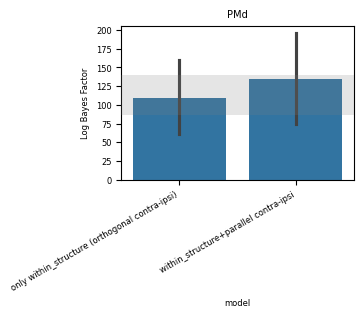

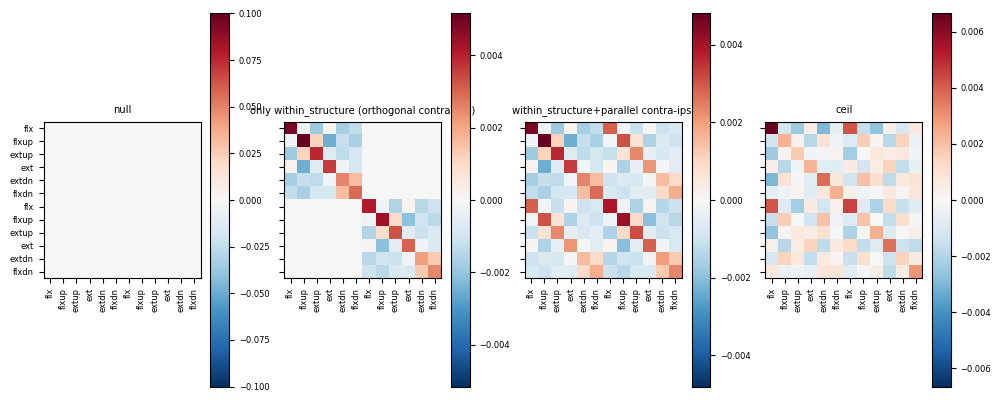

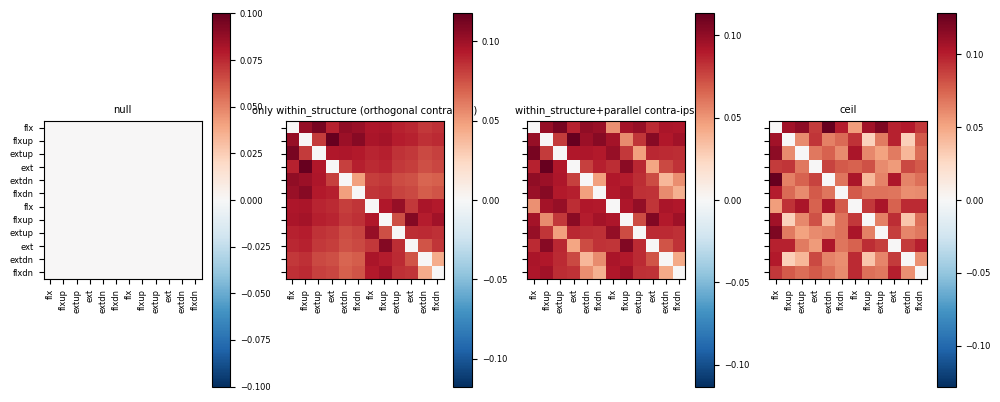

In [ ]:
# load model fits:
import pickle

regions = ['M1','S1','PMd','PMv','SMA','SPLa','SPLp','V1']
region = 'PMd'
# load model fitting:
with open(os.path.join(analysisDir, f'PCM_unimanual_{region}.pkl'), 'rb') as f:
    results = pickle.load(f)

T_gr = results['T_gr']
theta_gr = results['theta_gr']
nmodels = len(theta_gr)
T_cv = results['T_cv']
theta_cv = results['theta_cv']

fig, ax = plt.subplots(1,1,figsize=(3,2))
tmp_ax = pcm.model_plot(T_cv.likelihood,
                        null_model = 'null',
                        noise_ceiling= 'ceil',
                        upper_ceiling = T_gr.likelihood['ceil'])

# angle the x axis labels:
plt.xticks(rotation=30, ha='right')
plt.title(f'{region}')
# ax.set_ylim(-1, 100)
plt.show()

nmodels = len(M)

# set font:
matplotlib.rcParams.update({'font.size': 6})
# Plot model predictions:
fig, ax = plt.subplots(1, nmodels, figsize=(10,4), sharey=True)
for i in range(nmodels):
    G = M[i].predict(theta_gr[i][:M[i].n_param])[0]
    vmin = -np.max(np.abs(G))
    vmax = np.max(np.abs(G))
    ax[i].imshow(G, cmap=cmap, vmin=vmin, vmax=vmax)
    ax[i].set_title(M[i].name)
    ax[i].set_xticks(list(range(12)))
    ax[i].set_xticklabels(labels, rotation=90)
    ax[i].set_yticks(list(range(12)))
    ax[i].set_yticklabels(labels)
    plt.colorbar(ax[i].imshow(G, cmap=cmap, vmin=vmin, vmax=vmax), ax=ax[i])
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(1,nmodels, figsize=(10,4), sharey=True)
for i in range(nmodels):
    G = M[i].predict(theta_gr[i][:M[i].n_param])[0]
    D = pcm.G_to_dist(G)
    D = np.sign(D) * np.sqrt(np.abs(D))
    vmin = -np.max(np.abs(D))
    vmax = np.max(np.abs(D))
    ax[i].imshow(D, cmap=cmap, vmin=vmin, vmax=vmax)
    ax[i].set_title(M[i].name)
    ax[i].set_xticks(list(range(12)))
    ax[i].set_xticklabels(labels, rotation=90)
    ax[i].set_yticks(list(range(12)))
    ax[i].set_yticklabels(labels)
    plt.colorbar(ax[i].imshow(D, cmap=cmap, vmin=vmin, vmax=vmax), ax=ax[i])
plt.tight_layout()
plt.show()




# T-Test

In [ ]:
# load model fits:
import pickle

regions = ['M1','S1','PMd','PMv','SMA','SPLa','SPLp','V1']
region = 'PMd'
name = f'{region}'
# load model fitting:
with open(os.path.join(analysisDir, f'PCM_unimanual_{name}.pkl'), 'rb') as f:
    results = pickle.load(f)

T_gr = results['T_gr']
theta_gr = results['theta_gr']
nmodels = len(theta_gr)
T_cv = results['T_cv']
theta_cv = results['theta_cv']

# T-test between models:
from scipy import stats
likelihood = T_cv.likelihood
m_names = likelihood.columns.values
baseline = likelihood.loc[:,'null'].values
likelihood = likelihood - baseline.reshape(-1,1)

bayesfact = {'orthogonal contra-ipsi': [], 'parallel contra-ipsi': []}
bayesfact['orthogonal contra-ipsi'] = likelihood['only within_structure (orthogonal contra-ipsi)'].values
bayesfact['parallel contra-ipsi'] = likelihood['within_structure+parallel contra-ipsi'].values

# ttest each model > 0:
ttests = {}
for k in bayesfact.keys():
    t, p = stats.ttest_1samp(bayesfact[k], 0, alternative='greater')
    mean = np.mean(bayesfact[k])
    std = np.std(bayesfact[k])
    sem = stats.sem(bayesfact[k])
    ttests[k] = {'t': t, 'p': p, 'dof': len(bayesfact[k])-1, 'mean': mean, 'std': std, 'sem': sem}
    print(f'{k}: t({ttests[k]["dof"]})={t:.2f}, p={p:.4f}, mean={mean:.2f} std={std:.2f} sem={sem:.2f}')

# Model comparisons:
t, p = stats.ttest_rel(bayesfact['parallel contra-ipsi'], bayesfact['orthogonal contra-ipsi'], alternative='greater')
mean_diff = np.mean(bayesfact['parallel contra-ipsi'] - bayesfact['orthogonal contra-ipsi'])
std_diff = np.std(bayesfact['parallel contra-ipsi'] - bayesfact['orthogonal contra-ipsi'])
sem_diff = stats.sem(bayesfact['parallel contra-ipsi'] - bayesfact['orthogonal contra-ipsi'])
dof = len(bayesfact['parallel contra-ipsi']) - 1
print('\nModel comparison:')
print(f'Paired t-test parallel contra-ipsi > orthogonal contra-ipsi: t({dof})={t:.2f}, p={p:.4f}, mean_diff={mean_diff:.2f} std_diff={std_diff:.2f} sem_diff={sem_diff:.2f}')




orthogonal contra-ipsi: t(23)=4.25, p=0.0001, mean=109.17 std=123.05 sem=25.66
parallel contra-ipsi: t(23)=4.16, p=0.0002, mean=133.99 std=154.49 sem=32.21

Model comparison:
Paired t-test parallel contra-ipsi > orthogonal contra-ipsi: t(23)=2.05, p=0.0262, mean_diff=24.82 std_diff=58.19 sem_diff=12.13
